# CoMoFoD
* 512 x 512,
* 200 image sets,
* 40 images per transformation type,
* total number of images with postprocessed images = 10400.


dataset can be accessed from [here](https://www.vcl.fer.hr/comofod/download.html).


In [ ]:
!wget https://www.vcl.fer.hr/comofod/comofod_small.rar

--2024-01-24 17:52:03--  https://www.vcl.fer.hr/comofod/comofod_small.rar
Resolving www.vcl.fer.hr (www.vcl.fer.hr)... 161.53.16.144
Connecting to www.vcl.fer.hr (www.vcl.fer.hr)|161.53.16.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3213318957 (3.0G) [application/octet-stream]
Saving to: ‘comofod_small.rar’

comofod_small.rar   100%[===================>]   2.99G  7.80MB/s    in 17m 11s 

2024-01-24 18:09:15 (2.97 MB/s) - ‘comofod_small.rar’ saved [3213318957/3213318957]



In [ ]:
!unrar x comofod_small.rar

# Packages Import

In [21]:
import os
import shutil
import random
import re

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import albumentations as A

import tensorflow as tf
import tensorflow_datasets as tfds


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading Data

The dataset is downloaded and uploaded to google drive to use it in colab. The rar file is extracted then the data is loaded in order to be used with the augmentation pipeline. Before applying the augmentation, the data is split 75% training and validation, 25% testing. We have 200 images and 25% for testing is a decent ratio. Augmentation will also increase our dataset by 6X.

In [22]:
SIZE = (512, 512)
N_CLASSES = 2
N_IMAGES = 200
N_AUGMENTATION = 5
BATCH_SIZE = 32

SEED = 42

In [23]:
# Path to data
DATA_PATH = '/content/drive/MyDrive/CoMoFoD'
TRAIN_PATH = '/content/drive/MyDrive/CoMoFoD/train'
TEST_PATH = '/content/drive/MyDrive/CoMoFoD/test'

# Ensure the directories exists
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

os.makedirs(f"{TRAIN_PATH}/mask", exist_ok=True)
os.makedirs(f"{TRAIN_PATH}/mask_aug", exist_ok=True)
os.makedirs(f"{TRAIN_PATH}/image", exist_ok=True)
os.makedirs(f"{TRAIN_PATH}/image_aug", exist_ok=True)
os.makedirs(f"{TRAIN_PATH}/original_image", exist_ok=True)

os.makedirs(f"{TEST_PATH}/mask", exist_ok=True)
os.makedirs(f"{TEST_PATH}/image", exist_ok=True)
os.makedirs(f"{TEST_PATH}/original_image", exist_ok=True)

In [24]:
# Picking the images for training
binary_img_re = r'^\d+_B\.png$'
forg_img_re = r'^\d+_F\.png$'
org_img_re = r'^\d+_O\.png$'


for idx, image_name in enumerate(os.listdir(DATA_PATH)):
    if re.match(binary_img_re, image_name):
        shutil.copy(DATA_PATH + f"/{image_name}", TRAIN_PATH + f"/mask/{image_name}")

    elif re.match(forg_img_re, image_name):
        shutil.copy(DATA_PATH + f"/{image_name}", TRAIN_PATH + f"/image/{image_name}")

    elif re.match(org_img_re, image_name):
        shutil.copy(DATA_PATH + f"/{image_name}", TRAIN_PATH + f"/original_image/{image_name}")

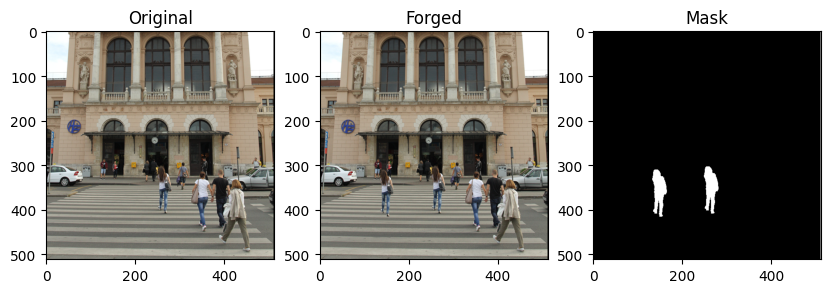

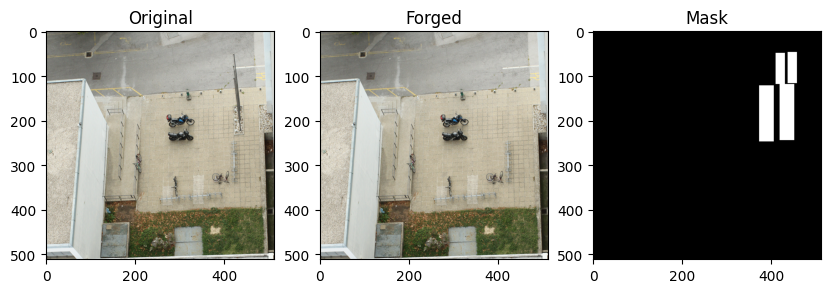

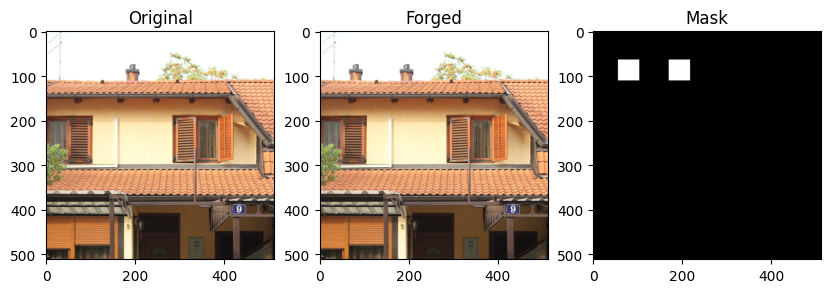

In [5]:
# Looking at some examples
prefixes = ["001", "002", "003"]

for prefix in prefixes:
    org_image = cv2.imread(f"{TRAIN_PATH}/original_image/{prefix}_O.png")
    org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)

    image = cv2.imread(f"{TRAIN_PATH}/image/{prefix}_F.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(f"{TRAIN_PATH}/mask/{prefix}_B.png")

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(org_image)
    axs[0].set_title("Original")
    axs[1].imshow(image)
    axs[1].set_title("Forged")
    axs[2].imshow(mask)
    axs[2].set_title("Mask")
    plt.show()

In [25]:
imgs_list = sorted(os.listdir(f"{TRAIN_PATH}/image"))
mask_list = sorted(os.listdir(f"{TRAIN_PATH}/mask"))
org_imgs_list = sorted(os.listdir(f"{TRAIN_PATH}/original_image"))

returned_lists = train_test_split(imgs_list,
                                    mask_list,
                                    org_imgs_list,
                                    test_size = 0.25,
                                    random_state=SEED)

img_train_list = returned_lists[0]
img_test_list = returned_lists[1]

mask_train_list = returned_lists[2]
mask_test_list = returned_lists[3]

org_imgs_train_list = returned_lists[4]
org_imgs_test_list = returned_lists[5]

In [26]:
# Checking that the images and masks matches well
for image, mask, org_img in zip(img_test_list, mask_test_list, org_imgs_test_list):
    print(image, mask, org_img)

096_F.png 096_B.png 096_O.png
016_F.png 016_B.png 016_O.png
031_F.png 031_B.png 031_O.png
159_F.png 159_B.png 159_O.png
129_F.png 129_B.png 129_O.png
116_F.png 116_B.png 116_O.png
070_F.png 070_B.png 070_O.png
171_F.png 171_B.png 171_O.png
175_F.png 175_B.png 175_O.png
046_F.png 046_B.png 046_O.png
067_F.png 067_B.png 067_O.png
183_F.png 183_B.png 183_O.png
166_F.png 166_B.png 166_O.png
079_F.png 079_B.png 079_O.png
187_F.png 187_B.png 187_O.png
178_F.png 178_B.png 178_O.png
057_F.png 057_B.png 057_O.png
153_F.png 153_B.png 153_O.png
083_F.png 083_B.png 083_O.png
069_F.png 069_B.png 069_O.png
125_F.png 125_B.png 125_O.png
017_F.png 017_B.png 017_O.png
149_F.png 149_B.png 149_O.png
094_F.png 094_B.png 094_O.png
066_F.png 066_B.png 066_O.png
061_F.png 061_B.png 061_O.png
085_F.png 085_B.png 085_O.png
068_F.png 068_B.png 068_O.png
126_F.png 126_B.png 126_O.png
133_F.png 133_B.png 133_O.png
010_F.png 010_B.png 010_O.png
019_F.png 019_B.png 019_O.png
056_F.png 056_B.png 056_O.png
076_F.png 

In [27]:
len(img_test_list)

50

In [28]:
for image, mask, org_img in zip(img_test_list, mask_test_list, org_imgs_test_list):
    shutil.move(f"{TRAIN_PATH}/image/{image}", f"{TEST_PATH}/image/{image}")
    shutil.move(f"{TRAIN_PATH}/mask/{mask}", f"{TEST_PATH}/mask/{mask}")
    shutil.move(f"{TRAIN_PATH}/original_image/{org_img}", f"{TEST_PATH}/original_image/{org_img}")


# Getting the TF dataset

In [9]:
# Load images
dataset_train_images = tf.keras.preprocessing.image_dataset_from_directory(
    f"{TRAIN_PATH}/image/",
    label_mode=None,  # Use 'label_mode="int"' if you have categorical labels
    image_size=SIZE,  # Resize images to this size (width, height)
    batch_size=BATCH_SIZE,  # Number of images to include in each batch
    shuffle=False,  # Important to maintain corresponding order with masks

)

# Load masks
dataset_train_masks = tf.keras.preprocessing.image_dataset_from_directory(
    f"{TRAIN_PATH}/mask/",
    label_mode=None,
    image_size=SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Important to maintain corresponding order with images
)

dataset_train = tf.data.Dataset.zip((dataset_train_images, dataset_train_masks))


Found 150 files belonging to 1 classes.
Found 150 files belonging to 1 classes.


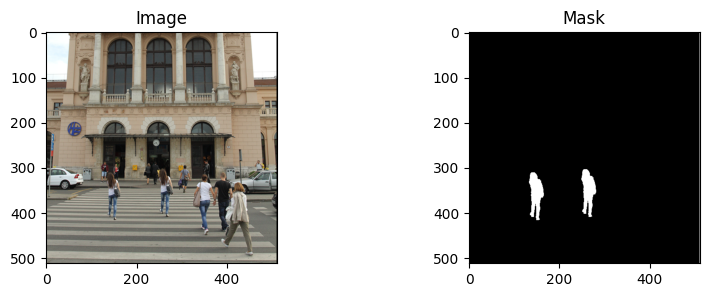

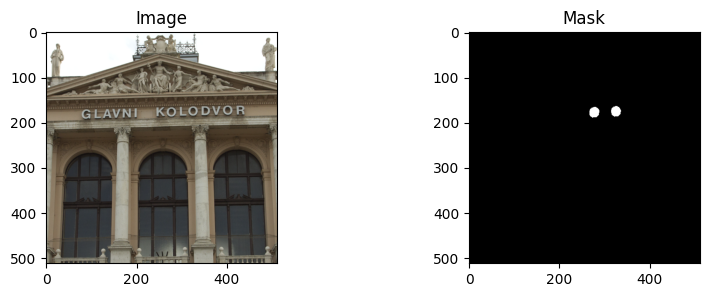

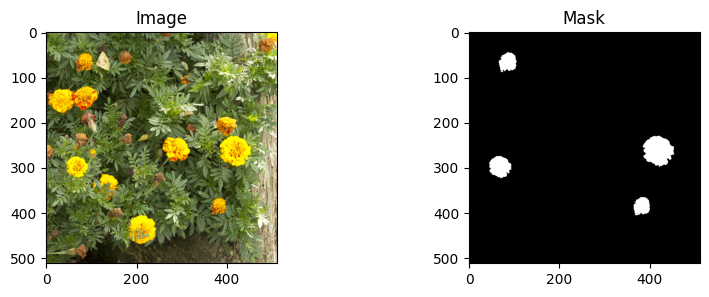

In [10]:
for image, mask in dataset_train.take(3):
    image_ = image[0].numpy().astype("uint8")
    mask_ = mask[0].numpy().astype("uint8")

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    axs[0].imshow(image_)
    axs[0].set_title("Image")
    axs[1].imshow(mask_)
    axs[1].set_title("Mask")
    plt.show()

Now the dataset is formated correctly and ready for augmentation



# Augmentation

Augmentation is important step in these tasks in order to create a more robust model. Since this is a multi-class segmentation various techniques likes rotation, flipping, dropout and other image manipulation techniques are applied.<br>
After applying the augmentations techniques, the images are normalized in order to feed them to our U-Net model

In [11]:
# Applying the augmentations
def augment(image, mask):
    try:
        # Define the augmentation pipeline
        augmentations = A.Compose([
            # Geometric transformations
            A.Rotate(limit=10, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),

            # Photometric transformations
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.2),
            A.GaussNoise(var_limit=(10.0, 100.0), p=0.5),

            # Advanced techniques
            A.CoarseDropout(max_holes=2, max_height=10, max_width=10, min_holes=1,
                            min_height=None, min_width=None, fill_value=0, p=0.5),
        ])

        # Apply the transformations
        augmented = augmentations(image=image.numpy().astype("uint8"), mask=mask.numpy().astype("uint8"))

        # Convert back to tensors
        image_tensor = tf.convert_to_tensor(augmented['image'], dtype=tf.float32)
        mask_tensor = tf.convert_to_tensor(augmented['mask'], dtype=tf.float32)

        return image_tensor, mask_tensor
    except Exception as e:
        print(f"Error in augmentation: {e}")
        print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
        # Handle the error as appropriate - skip this image, use a default image, etc.

def tf_augment(image, mask):
    image_aug, mask_aug = tf.py_function(augment, [image, mask], [tf.float32, tf.float32])
    # Ensure that the output shape is set correctly as tf.py_function loses shape information
    image_aug.set_shape(image.shape)
    mask_aug.set_shape(mask.shape)

    # # Clip the image data to ensure it's within the [0, 1] range
    # image_aug = tf.clip_by_value(image_aug, clip_value_min=0.0, clip_value_max=1.0)
    # mask_aug = tf.clip_by_value(mask_aug, clip_value_min=0.0, clip_value_max=1.0)

    return image_aug, mask_aug

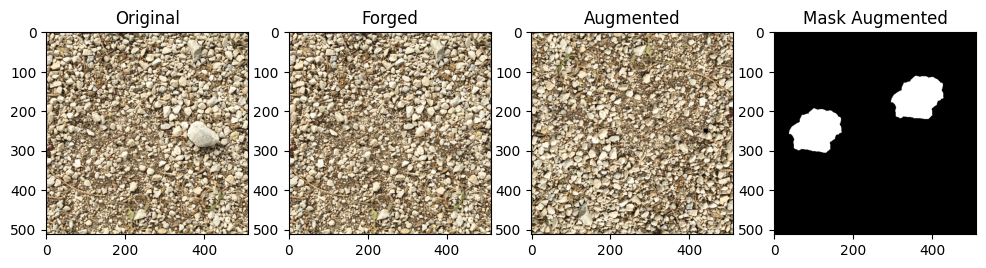

In [12]:
prefix = "150"

org_image = cv2.imread(f"{TRAIN_PATH}/original_image/{prefix}_O.png")
org_image = cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB)

image = cv2.imread(f"{TRAIN_PATH}/image/{prefix}_F.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(f"{TRAIN_PATH}/mask/{prefix}_B.png")


image_aug, mask_aug = tf_augment(image, mask)

fig, axs = plt.subplots(1, 4, figsize=(12, 5))
image_aug = (image_aug - np.min(image_aug)) / (np.max(image_aug) - np.min(image_aug))
mask_aug = (mask_aug - np.min(mask_aug)) / (np.max(mask_aug) - np.min(mask_aug))


axs[0].imshow(org_image)
axs[0].set_title("Original")
axs[1].imshow(image)
axs[1].set_title("Forged")
axs[2].imshow(image_aug)
axs[2].set_title("Augmented")
axs[3].imshow(mask_aug)
axs[3].set_title("Mask Augmented")
plt.show()

In [13]:
aug_dataset_train = dataset_train.unbatch().map(tf_augment)

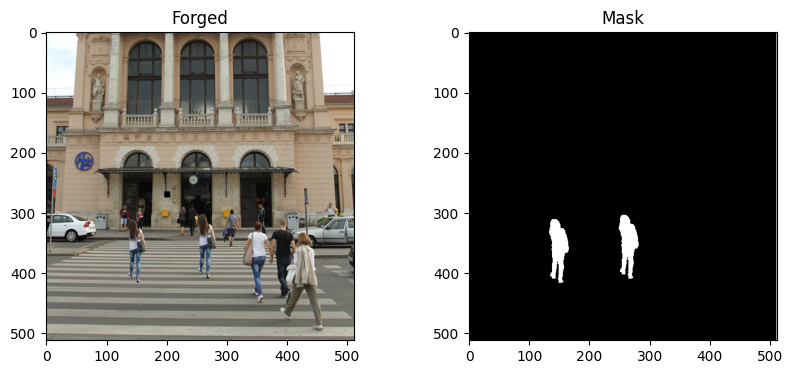

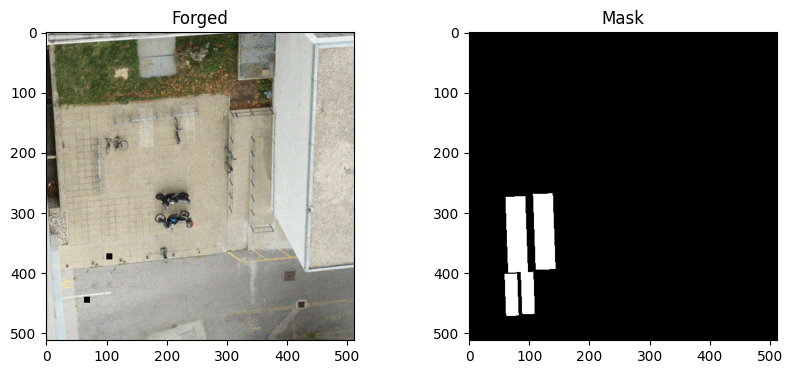

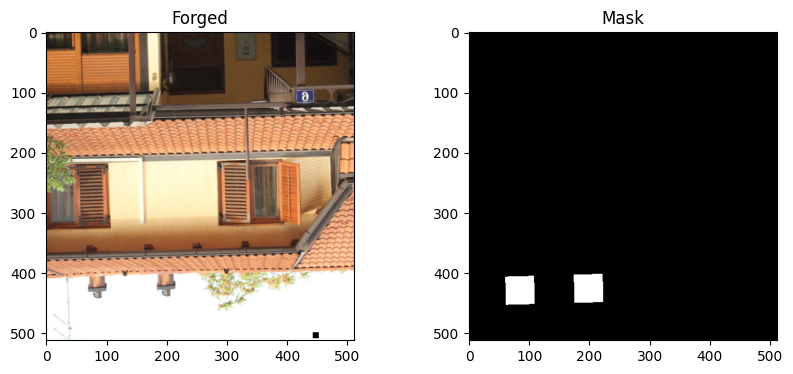

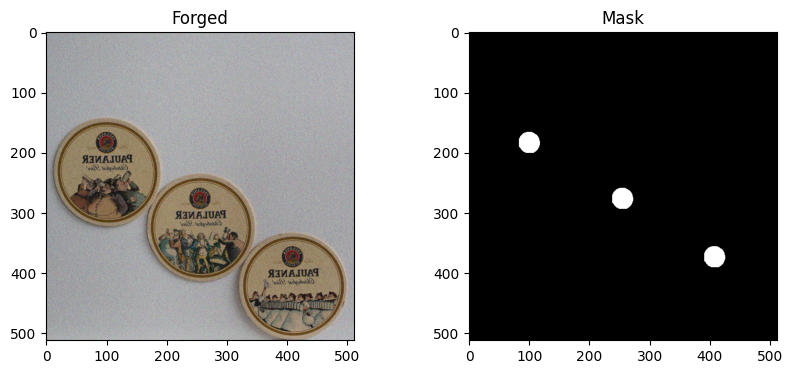

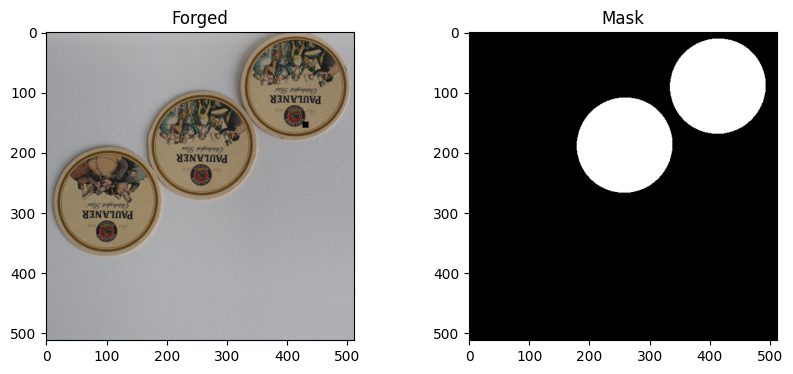

In [14]:
for image, mask in aug_dataset_train.take(5):
    image = image.numpy().astype("uint8")
    mask = mask.numpy().astype("uint8")

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(image)
    axs[0].set_title("Forged")

    axs[1].imshow(mask)
    axs[1].set_title("Mask")
    plt.show()

In [15]:
all_datasets = [dataset_train.unbatch()]

for _ in range(N_AUGMENTATION):
    # Augment the original dataset
    augmented_dataset = dataset_train.unbatch().map(tf_augment)

    # Add the augmented dataset to the list
    all_datasets.append(augmented_dataset)

# Concatenate all datasets together
concatenated_dataset = all_datasets[0]
for dataset_to_add in all_datasets[1:]:
    concatenated_dataset = concatenated_dataset.concatenate(dataset_to_add)

# Shuffle the concatenated dataset
concatenated_dataset = concatenated_dataset.shuffle(buffer_size=10000)

# Optional: batch the dataset if needed
concatenated_dataset = concatenated_dataset.batch(BATCH_SIZE)


In [16]:
def normalize(image, mask):
    # Normalize image to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, mask

normalized_dataset_train = concatenated_dataset.map(normalize)

In [20]:
for images, masks in normalized_dataset_train.take(1):
    # If the dataset is batched, features and labels will have batch dimension as first dimension
    print("Batch size:", images.shape[0])
    print("Features Batch shape:", images.shape)
    print("Labels Batch shape:", masks.shape)
    print("Feature shape per sample:", images.shape[1:])
    print("Max Value in Feature:", tf.reduce_max(images[0]).numpy())
    print("Label shape per sample:", masks.shape[1:])
    print("Label unique values:", tf.unique(tf.reshape(masks[0], [-1])).y.numpy())


Batch size: 32
Features Batch shape: (32, 512, 512, 3)
Labels Batch shape: (32, 512, 512, 3)
Feature shape per sample: (512, 512, 3)
Max Value in Feature: 1.0
Label shape per sample: (512, 512, 3)
Label unique values: [  0. 255.]


# Saving Data to Disk

After preprocessing the train data, it's saved to the disk in order to used in the next stage for the model training. The test dataset is also saved to the disk.

In [ ]:
# Save the dataset
tf.data.Dataset.save(normalized_dataset_train, '/content/drive/MyDrive/cv_data/train')

# Saving Raw Augmented Images

In [29]:
# Define the augmentation pipeline
augmentations = A.Compose([
    # Geometric transformations
    A.Rotate(limit=10, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    # Photometric transformations
    A.RandomBrightnessContrast(brightness_limit=0.2,
                                contrast_limit=0.2, p=0.2),
    A.ColorJitter(brightness=0.2, contrast=0.2,
                    saturation=0.2, hue=0.2, p=0.2),
    A.GaussNoise(var_limit=(10.0, 100.0), p=0.5),

    # Advanced techniques
    A.CoarseDropout(max_holes=2, max_height=10, max_width=10, min_holes=1,
                    min_height=None, min_width=None, fill_value=0, p=0.5),
])


# Applying the augmentations
def augment(augmentations, image, mask):
    try:
        # Apply the transformations
        augmented = augmentations(image=image.astype("uint8"),
                                  mask=mask.astype("uint8"))
        return (augmented['image'], augmented['mask'])

    except Exception as e:
        print(f"Error in augmentation: {e}")
        print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
        # Handle the error as appropriate - skip this image, use a default image, etc.


In [32]:
img_train_list = sorted(os.listdir(f"{TRAIN_PATH}/image"))
mask_train_list = sorted(os.listdir(f"{TRAIN_PATH}/mask"))

In [33]:
# Checking that the images and masks matches well
for image, mask in zip(img_train_list, mask_train_list):
    print(image, mask)

001_F.png 001_B.png
002_F.png 002_B.png
003_F.png 003_B.png
004_F.png 004_B.png
005_F.png 005_B.png
006_F.png 006_B.png
007_F.png 007_B.png
008_F.png 008_B.png
009_F.png 009_B.png
011_F.png 011_B.png
012_F.png 012_B.png
013_F.png 013_B.png
014_F.png 014_B.png
015_F.png 015_B.png
018_F.png 018_B.png
021_F.png 021_B.png
022_F.png 022_B.png
023_F.png 023_B.png
024_F.png 024_B.png
026_F.png 026_B.png
027_F.png 027_B.png
028_F.png 028_B.png
029_F.png 029_B.png
032_F.png 032_B.png
033_F.png 033_B.png
034_F.png 034_B.png
035_F.png 035_B.png
036_F.png 036_B.png
037_F.png 037_B.png
038_F.png 038_B.png
040_F.png 040_B.png
041_F.png 041_B.png
042_F.png 042_B.png
043_F.png 043_B.png
044_F.png 044_B.png
045_F.png 045_B.png
047_F.png 047_B.png
048_F.png 048_B.png
049_F.png 049_B.png
050_F.png 050_B.png
051_F.png 051_B.png
052_F.png 052_B.png
053_F.png 053_B.png
054_F.png 054_B.png
055_F.png 055_B.png
058_F.png 058_B.png
059_F.png 059_B.png
060_F.png 060_B.png
062_F.png 062_B.png
063_F.png 063_B.png


In [34]:
for i in range(5):
    for image_name, mask_name in zip(img_train_list, mask_train_list):
        image = cv2.imread(f"{TRAIN_PATH}/image/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(f"{TRAIN_PATH}/mask/{mask_name}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        image_aug, mask_aug = augment(augmentations, image, mask)

        img_aug_name = image_name.replace("F", f"F_A_{i}")
        mask_aug_name = mask_name.replace("B", f"B_A_{i}")

        cv2.imwrite(f"{TRAIN_PATH}/image_aug/{img_aug_name}", image_aug)
        cv2.imwrite(f"{TRAIN_PATH}/mask_aug/{mask_aug_name}", mask_aug)